In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile
from scipy.io import savemat
from scipy.signal import correlate
import IPython
import heapq

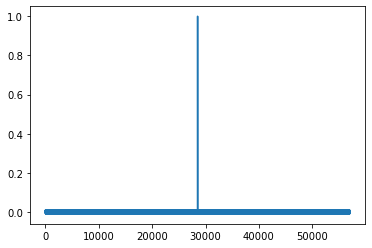

(57040,)


In [2]:
#uni_white_noise = np.random.uniform(-1,1,57040)
uni_white_noise = np.random.uniform(-0.01,0.01,57040)
uni_white_noise[28520] = 1

plt.plot(uni_white_noise)
plt.show()
print(uni_white_noise.shape)

In [3]:
def get_rir(size='medium', absorption='medium', order = 0):
    if absorption=='high':
        absor = 0.9
    elif absorption=='medium':
        absor = 0.3
    elif absorption=='low':
        absor = 0.1
    else:
        raise ValueError("The absorption parameter can only take values ['low', 'medium', 'high']")
    
    if size=='large':
        size_coef = 5.
    elif size=='medium':
        size_coef = 2.5
    elif size=='small':
        size_coef = 1.
    else:
        raise ValueError("The size parameter can only take values ['small', 'medium', 'large']")
        
        
    pol = size_coef * np.array([[0,0], [0,6], [5,6], [5,0]]).T
    room = pra.Room.from_corners(pol, fs=16000, max_order=order, absorption=absor)

    # Create the 3D room by extruding the 2D by a specific height
    room.extrude(size_coef * 2.5, absorption=absor)

    # Adding the source
    room.add_source(size_coef * np.array([1.8, 0.4, 1.6]), signal=uni_white_noise)

    # Adding the microphones
    R = size_coef * np.array([[2.5, 2.9, 0.5], 
                              [2.0, 2.0, 0.8], 
                              [1.5, 1.5, 1.0], 
                              [1.0, 0.5, 0.6], 
                              [2.5, 0.5, 1.0],
                              [2.9, 1.0, 1.2],
                              [0.5, 1.5, 1.0],
                              [0.8, 3.5, 1.5],
                              [2.9, 2.5, 1.0],
                              [2.0, 3.9, 1.6]])
    R = np.transpose(R)
    room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

    # Compute the RIR
    room.compute_rir()

    # Plot and apply the RIR on the audio file
    #room.plot_rir()
    #plt.show()
    room.simulate()
    room.mic_array.to_wav('aaa.wav', norm=True, bitdepth=np.int16)
    
    # Display the audio file
    fs_result, result = wavfile.read('aaa.wav')
    #IPython.display.display(IPython.display.Audio(result, rate=fs_result))
    
    return room.rir

/home/manav/anaconda3/lib/python3.8/site-packages/pyroomacoustics/room.py:1163: UserWarning: Using absorption parameter is deprecated. In the future, use materials instead.
  warnings.warn(
<ipython-input-4-58d19dc2e74e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rir_small = np.array(rir_small)


(10, 1)


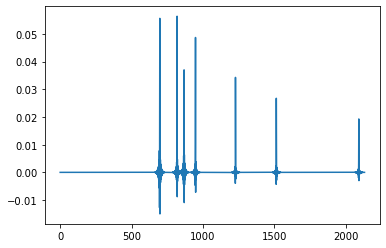

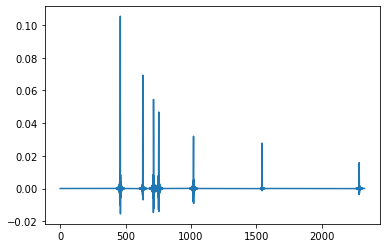

In [4]:
rir_small = get_rir(size='large', absorption='low', order = 1)

rir_small = np.array(rir_small)
print(rir_small.shape)

plt.plot(rir_small[0][0])
plt.show()

plt.plot(rir_small[1][0])
plt.show()

In [5]:
rir_done = []

for i in range(10):
    for row in rir_small[i]:
        rir_done.append(row)
        print(len(row))

2133
2329
2442
2688
2679
2569
2461
1985
2224
1878


In [6]:
out = []

for i in range(10):
    o = np.convolve(uni_white_noise, rir_done[i])
    out.append(o)

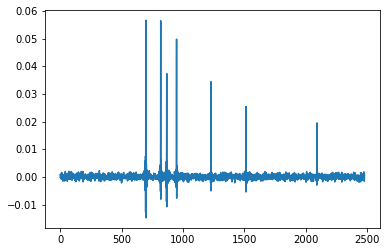

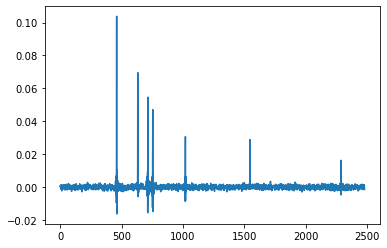

[29217, 29218, 29339, 29387, 29388, 29468, 29748, 30034, 30612]
[0.043625, 0.0511875, 0.0541875, 0.05925, 0.07675, 0.094625, 0.13075]


In [17]:
plt.plot(out[0][57040//2:31000])
plt.show()

plt.plot(out[1][57040//2:31000])
plt.show()

peaks = []
thresh = 0.015

for i in range(len(out[0])):
    if(out[0][i] > thresh):
        peaks.append(i)
print(peaks)
        
idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 2):
        idx.append(i)
        
for i in range(len(idx)):
    peaks.pop(idx[i])
        
for i in range(len(peaks)):
    peaks[i] = peaks[i] - (57040//2)#Centering at zero
    peaks[i] = float(peaks[i])/16000 #Dividing by Sampling Frequency to get answers in seconds
    
print(peaks)

59172
59368


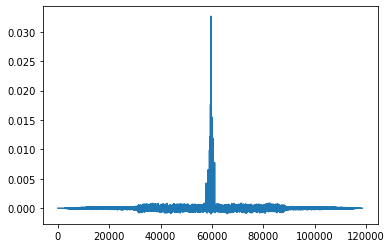

In [167]:
print(len(out[0]))
print(len(out[1]))
ans = correlate(out[0],out[1],"full")
ans2 = correlate(out[1], out[0], "full")

plt.plot(ans)
plt.show()

In [168]:
print(heapq.nlargest(1,range(len(ans)),ans.take))
print(heapq.nlargest(1,range(len(ans2)), ans2.take))

[59605]
[58933]


In [169]:
tij = np.zeros((10,10))
cnt = 0

for i in range(10):
    for j in range(10):
        print(cnt)
        cnt = cnt + 1
        if(i == j):
            continue
        else:
            ans = np.correlate(out[i],out[j],"full")
            val = heapq.nlargest(1,range(len(ans)),ans.take)
            tij[i][j] = val[0]/16000
            
print(abs(tij))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[[0.        3.7253125 3.7398125 3.75525   3.759875  3.747375  3.7335
  3.6825625 3.7093125 3.67225  ]
 [3.6833125 0.        3.7249375 3.740375  3.7450625 3.7325    3.718625
  3.6676875 3.6944375 3.657375 ]
 [3.675875  3.703     0.        3.7329375 3.7375625 3.7250625 3.711125
  3.6601875 3.687     3.6499375]
 [3.6758125 3.7029375 3.7174375 0.        3.7375    3.725     3.7110625
  3.6601875 3.6869375 3.649875 ]
 [3.670625  3.6976875 3.71225   3.7276875 0.        3.7198125 3.705875
  3.6549375 3.68175   3.6446875]
 [3.67625   3.703375  3.717875  3.7333125 3.7379375 0.        3.7115625
  3.660625  3.687375  3.6503125]
 [3.683375  3.7105    3.7250625 3.7405    3.745125  3.7325625 0.
  3.66775   3.6945625